## **Week 12: Convolutional Neural Networks**

#### Compiled by Dr. Sunu Wibirama
**Diclaimer:** <br/> This modul is part of hands on supplement for undergraduate course "Kecerdasan Buatan" (Artificial Intelligence) in The Department of Electrical and Information Engineering, Faculty of Engineering, Universitas Gadjah Mada, Indonesia. All codes are for solely educational purposes to explain lecture materials and provide deeper understanding on the presented materials. <br/><br/>

### Objectives of the Jupyter notebook

* Learning how to prepare data specifically for a CNN
* Creating a sophisticated CNN model, understanding a greater variety of model layers
* Training a CNN model and observe its performance

### CNN for classifying ASL images

This Jupyter notebook shows you how to build a Convolutional Neural Network (CNN) from Scatch to classify image of American Sign Language. You may read some additional theory of CNN [here](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53). American Sign Language, is a natural language that serves as the predominant sign language of Deaf communities in the United States of America and most of Anglophone Canada. ASL is a complete and organized visual language that is expressed by employing both manual and nonmanual features. The [ASL alphabet](http://www.asl.gs/) contains 26 letters. Two of those letters (j and z) require movement, so they are not included in the training dataset. 
<br/><br/>
This dataset is available from the website [Kaggle](http://www.kaggle.com), which is a fantastic place to find datasets and other deep learning resources. In addition to providing resources like datasets and "kernels" that are like these notebooks, Kaggle hosts competitions that you can take part in, competing with others in training highly accurate models.
<br/><br/>

<img src='https://drive.google.com/uc?id=1X2VXXWVjPwUbuOITwKXpmfjOTTvN705H' width="600" 
     height="400"/>


## Loading and Preparing the Data

First, we have to mount the Google Drive. Note that you have to modify the system path to match with your own Google Drive path.

In [25]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
import sys
path = sys.path.append('/content/gdrive/MyDrive/2022 Kuliah Kecerdasan Buatan/Semester Genap/week12-Jupyter Code/Jupyter Notebook CNN')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


The sign language dataset is in [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) (Comma Separated Values) format, the same data structure behind Microsoft Excel and Google Sheets. It is a grid of rows and columns with labels at the top, as seen in the train and valid (they may take a moment to load).

To load and work with the data, we'll be using a library called [Pandas](https://pandas.pydata.org/), which is a highly performant tool for loading and manipulating data. We'll read the CSV files into a format called a [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [26]:
import tensorflow.keras as keras
import pandas as pd

# Load in our data from CSV files
os.chdir('/content/gdrive/MyDrive/2022 Kuliah Kecerdasan Buatan/Semester Genap/week12-Jupyter Code/Jupyter Notebook CNN')
train_df = pd.read_csv("data/asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv("data/asl_data/sign_mnist_valid.csv")

# Separate out our target values
y_train = train_df['label']
y_valid = valid_df['label']
del train_df['label']
del valid_df['label']

## Summarizing our training data

We now have 27,455 images with 784 pixels each for training...

In [27]:
x_train.shape

(27455, 784)

...as well as their corresponding labels:

In [28]:
y_train.shape

(27455,)

For validation, we have 7,172 images...

In [29]:
x_valid.shape

(7172, 784)

...and their corresponding labels:

In [30]:
y_valid.shape

(7172,)

## Visualizing the data

To visualize the images, we will again use the matplotlib library. We don't need to worry about the details of this visualization, but if interested, you can learn more about [matplotlib](https://matplotlib.org/) at a later time.

Note that we'll have to reshape the data from its current 1D shape of 784 pixels, to a 2D shape of 28x28 pixels to make sense of the image:

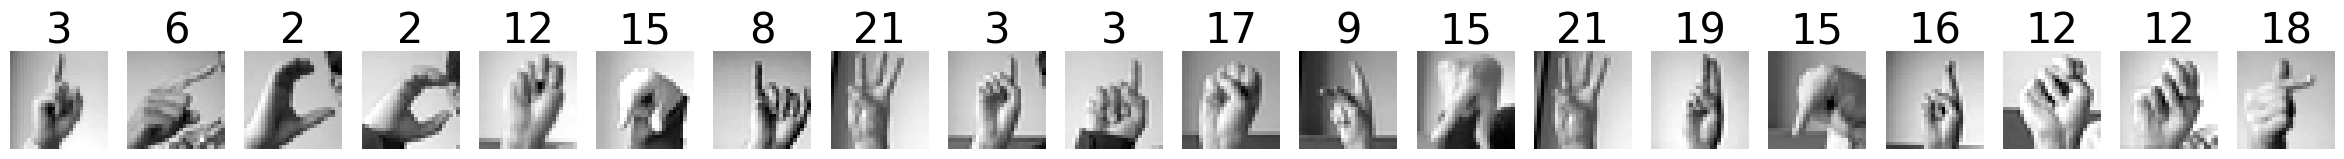

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))

num_images = 20
for i in range(num_images):
    row = x_train[i]
    label = y_train[i]
    
    image = row.reshape(28,28)
    plt.subplot(1, num_images, i+1)
    plt.title(label, fontdict={'fontsize': 30})
    plt.axis('off')
    plt.imshow(image, cmap='gray')

### Data normalization

Next, we turn our scalar targets (label) into binary categories and normalizes the images, so that the intensity range is changed from (0-255) to (0-1). The image data are normalized by dividing the intensity value with 255.

In [34]:

# Separate out our image vectors
x_train = train_df.values
x_valid = valid_df.values

# Turn our scalar targets into binary categories
num_classes = 24
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# Normalize our image data
x_train = x_train / 255
x_valid = x_valid / 255

## Reshaping Images for a CNN

The individual pictures in our dataset are in the format of long lists of 784 pixels:

In [35]:
x_train.shape, x_valid.shape

((27455, 784), (7172, 784))

In this format, we don't have all the information about which pixels are near each other. Because of this, we can't apply convolutions that will detect features. Let's reshape our dataset so that they are in a 28x28 pixel format. This will allow our convolutions to associate groups of pixels and detect important features.

Note that for the first convolutional layer of our model, we need to have not only the height and width of the image, but also the number of [color channels](https://www.photoshopessentials.com/essentials/rgb/). Our images are grayscale, so we'll just have 1 channel.

That means that we need to convert the current shape `(27455, 784)` to `(27455, 28, 28, 1)`. As a convenience, we can pass the [reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html#numpy.reshape) method a `-1` for any dimension we wish to remain the same, therefore:

In [36]:
x_train = x_train.reshape(-1,28,28,1)
x_valid = x_valid.reshape(-1,28,28,1)

In [37]:
x_train.shape

(27455, 28, 28, 1)

In [38]:
x_valid.shape

(7172, 28, 28, 1)

In [39]:
x_train.shape, x_valid.shape

((27455, 28, 28, 1), (7172, 28, 28, 1))

## Creating a Convolutional Model

These days, many data scientists start their projects by borrowing model properties from a similar project. Assuming the problem is not totally unique, there's a great chance that people have created models that will perform well which are posted in online repositories like [TensorFlow Hub](https://www.tensorflow.org/hub) and the [NGC Catalog](https://ngc.nvidia.com/catalog/models).

<img src='https://drive.google.com/uc?id=1vdQGZuiz78h61rrigXylDC_ZXFm8fr9M' width="250" 
     height="500"/>

### [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)


<img src='https://drive.google.com/uc?id=1-yZJ3iLyFPiCFgY1_dn8-91krqmCSEme' width="500" 
     height="200"/>

These are our 2D convolutional layers. Small kernels will go over the input image and detect features that are important for classification. Earlier convolutions in the model will detect simple features such as lines. Later convolutions will detect more complex features. Let's look at our first Conv2D layer:
```Python
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same'...)
```
Note: 
75 refers to the number of filters that will be learned. (3,3) refers to the size of those filters. Strides refer to the step size that the filter will take as it passes over the image. Padding refers to whether the output image that's created from the filter will match the size of the input image. 

### [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)

Batch Normalization is about normalizing the hidden units activation values so that the distribution of these activations remains same during training. During training of any deep neural network if the hidden activation distribution changes because of the changes in the weights and bias values at that layer, they cause rapid changes in the layer above it. This slows down the training a lot. The change in distribution of the hidden activations during is called internal covariate shift which effect the training speed of the network.
Some articles about batch normalization: 
* [Batch normalization in neural networks by Yash Agarwal](https://medium.com/@yagrawal.ya/batch-normalization-in-neural-networks-5c71e02eb45b)
* [Understanding batch normalization by Khrisna Dn](https://medium.com/@krishna_84429/understanding-batch-normalization-1eaca8f2f63e)

### [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)

<img src='https://drive.google.com/uc?id=1kGCoerUu8FeASXOE3PBectYtVY9JR-ml' width="500" 
     height="200"/>

Max pooling takes an image and essentially shrinks it to a lower resolution. It does this to help the model be robust to translation (objects moving side to side), and also makes our model faster.

### [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)

<img src='https://drive.google.com/uc?id=1TbQprsp4jLjA5Z4R81fDcRbmcoEdwyvJ' width="500" 
     height="200"/>

Dropout is a technique for preventing overfitting. Dropout randomly selects a subset of neurons and turns them off, so that they do not participate in forward or backward propagation in that particular pass. This helps to make sure that the network is robust and redundant, and does not rely on any one area to come up with answers.    

### [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)

Flatten takes the output of one layer which is multidimensional, and flattens it into a one-dimensional array. The output is called a feature vector and will be connected to the final classification layer.

### [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

We have seen dense layers before in our earlier models. Our first dense layer (512 units) takes the feature vector as input and learns which features will contribute to a particular classification. The second dense layer (24 units) is the final classification layer that outputs our prediction.

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

## Summarizing the Model

This may feel like a lot of information, but don't worry. It's not critical that to understand everything right now in order to effectively train convolutional models. Most importantly we know that they can help with extracting useful information from images, and can be used in classification tasks.

Here, we summarize the model we just created: 

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 75)        750       
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 75)       300       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 75)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_7 (Batc  (None, 14, 14, 50)      

## Compiling the Model

We will [compile](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#compile) our model using [categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) to reflect the fact that we want to fit into one of many categories, and measuring the accuracy of our model:

In [42]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

## Training the Model

Run the cell below to train for 20 epochs:

In [43]:
model.fit(x_train, y_train, epochs=20, verbose=1, validation_data=(x_valid, y_valid))

Epoch 1/20
858/858 [==============================] - 9s 8ms/step - loss: 0.2981 - accuracy: 0.9073 - val_loss: 0.4011 - val_accuracy: 0.8781
Epoch 2/20
858/858 [==============================] - 7s 8ms/step - loss: 0.0179 - accuracy: 0.9938 - val_loss: 1.8499 - val_accuracy: 0.6299
Epoch 3/20
858/858 [==============================] - 7s 8ms/step - loss: 0.0104 - accuracy: 0.9970 - val_loss: 0.2014 - val_accuracy: 0.9442
Epoch 4/20
858/858 [==============================] - 6s 6ms/step - loss: 0.0074 - accuracy: 0.9975 - val_loss: 0.2167 - val_accuracy: 0.9499
Epoch 5/20
858/858 [==============================] - 6s 7ms/step - loss: 0.0064 - accuracy: 0.9981 - val_loss: 0.3201 - val_accuracy: 0.9230
Epoch 6/20
858/858 [==============================] - 6s 7ms/step - loss: 0.0032 - accuracy: 0.9988 - val_loss: 0.1391 - val_accuracy: 0.9679
Epoch 7/20
858/858 [==============================] - 7s 8ms/step - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.1083 - val_accuracy: 0.9681
Epoch 

## Discussion of Results

The training accuracy is very high, and the validation accuracy has improved as the epoch increases. 

You may have noticed the validation accuracy jumping around. This is an indication that our model is still not generalizing perfectly. How do you solve this problem? If you are interested, you may find some information in the [Stackoverflow website](https://stackoverflow.com/). 

**Note:** <br/>
In order to further improve performance, you can try *data augmentation*, a collection of techniques that will allow your models to train on more and better data than what you might have originally at your disposal.

## Summary

In this section, we utilized several layers to implement a CNN to classify ASL images. Using this notebook, hopefully you can understand the whole process of using CNN to classify ASL images. Please note that there are many ways to improve the performance of your deep learning model.